In [1]:
#Importing relevant packages 

import numpy as np
import pandas as pd
from datetime import datetime #To check start and end time when running code
from tqdm import tqdm #This is for creating progress bars.
import logging #This is to provide logging of information when running the LDA
import sys #This is to disable logging when it's no longer needed
import pickle #To store and open previously saved machine learning models 

#Importing NLTK and NLP packages
import nltk
from nltk.tokenize import TweetTokenizer
import string
import re
from collections import defaultdict

#Importing packages for data visualization 
import matplotlib.pyplot as plt
import seaborn as sns

#Importing packages for LDA
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamulticore import LdaMulticore


# TOPIC MODELLING 

In this lab, we will apply a 50-topic LDA model to tweets from US Members of Congress to examine discussions about COVID-19 by Democrats and Republicans over time. Who was quicker to set the agenda around COVID-19, Democrats or Republicans? Make a guess if you know something about US politics.

The dataset is similar to last week's scaling lab and has been preprocessed similarly, with the main exception being that this time tweets are subsetted from 2019 and later, because we are mainly interested in tweets that (may) capture the COVID-19 crisis. The preprocessed dataset is called 'MOCTweets_preprocessed.csv'. 

#### If you wish to replicate the preprocessing, these are the steps taken for this dataset:

1. Changing 'date' from str type object to datetime type 
2. Subsetting to 2019 and later 
3. Removing unneeded columns (all except 'date', 'text', 'affiliation', and 'nominate_name')
2. Removing duplicated tweets 
7. Turning independents into Democrats or Republicans. In essence, finding the independents ("SANDERS, Bernard" and "KING, Angus Stanley, Jr.") and turning these to "Democrat". 
7. Removing instances of "&amp"
8. Replacing all remaining "&" with "and"
8. Removing odd special characters that show up in topic model ("┻","┃","━","┳","┓","┏","┛")
9. There are some annoying cases in these data where a character that looks like a space is not a space. Here, we just replace that character with an actual space. Replacing "\u202F", "\u2069", "\u200d", and "\u2066" with " ".
6. Removing "RT" and "via"
11. Removing mentions (@someone)
10. Removing numbers, removing punctuation (except hyphens and #), removing separators, removing urls, lowercasing, removing stopwords, lemmatizing, and stemming.


In [2]:
#Importing and viewing data
tweets = pd.read_csv("MOC_Tweets.csv")
tweets.head(3)

,Unnamed: 0,user_id,num_tweets,raw_url,url,url_tweet_part,tweet_type,date,tweet_id,retries,text_user_id,text,geography,affiliation,nominate_name
0,1,5558312.0,430143,none,none,none,authored,20190319,1.108000e+18,999999,5558312.0,Federal government employees are dedicated pub...,AR,Republican,"BOOZMAN, John"
1,2,5558312.0,430143,none,none,none,authored,20170803,8.929066e+17,999999,5558312.0,Congrats to @SenTomCotton's Sand Lizards on th...,AR,Republican,"BOOZMAN, John"
2,3,5558312.0,430143,https://twitter.com/60Minutes/status/656077372...,https://twitter.com/60Minutes/status/656077372...,author,quote,20151019,6.560929e+17,0,5558312.0,WATCH: I applaud Northeast #Arkansas residents...,AR,Republican,"BOOZMAN, John"


In [3]:
#Checking dataset shape
tweets.shape

(1615238, 15)

In [4]:
#Change date from str object to datetime object
tweets['date'] = pd.to_datetime(tweets['date'], format = '%Y%m%d', errors = 'ignore')


In [5]:
#Subsetting the data to span 2019 and later 
tweets = tweets.loc[tweets.date > datetime(2018,12,31)]

#Checking new dataset shape
tweets.shape


(585744, 15)

In [6]:
#Removing duplicated tweets 
tweets = tweets.drop_duplicates(subset = 'tweet_id')

#Checking new dataset shape 
tweets.shape

(579820, 15)

In [7]:
#Redefining dataset to only include useful columns 
tweets = tweets[['date','text','affiliation','nominate_name']]


In [8]:
#Locating politicians marked as 'Independent' affiliation and turning these into Democrats

print(tweets.loc[tweets.affiliation == 'Independent']['nominate_name'].value_counts())

tweets['affiliation'] = tweets['affiliation'].apply(lambda x: 'Democrat' if x == 'Independent' else x)


SANDERS, Bernard            1512
KING, Angus Stanley, Jr.     557
Name: nominate_name, dtype: int64


In [9]:
#Check if all 'Independent' were converted. Looks like it. 
print(tweets.affiliation.value_counts())

Democrat      371662
Republican    208158
Name: affiliation, dtype: int64


In [10]:
#Reusing and tweaking the function for preprocessing from last week to fit specifics of this dataset.

def preprocess(text):
    
    #Lowercasing words
    text = text.lower()
    
    #Removing '&amp' which was found to be common
    text = re.sub(r'&amp','', text)
    
    #Replace other instances of "&" with "and"
    text = re.sub(r'&','and', text)
    
    #Removing mentions 
    text = re.sub(r'@\w+ ', '', text)
    
    #Removing 'RT' and 'via'
    text = re.sub(r'(^rt|^via)((?:\b\W*@\w+)+): ', '', text)
    
    #Removing punctuation
    
    my_punctuation = string.punctuation.replace('#','')
    my_punctuation = my_punctuation.replace('-','')
    
    text = text.translate(str.maketrans('', '', my_punctuation))
    text = re.sub(r' - ','', text) #removing dash lines bounded by whitespace (and therefore not part of a word)
    text = re.sub(r'[’“”—,!]','',text) #removing punctuation that is not captured by string.punctuation
    
    #Removing odd special characters
    text = re.sub(r"[┻┃━┳┓┏┛┗]","", text)
    text = re.sub(r"\u202F|\u2069|\u200d|\u2066","", text)
    
    #Removing URLs
    text = re.sub(r'http\S+', '', text)
    
    #Removing numbers
    text = re.sub(r'[0-9]','', text)
    
    #Removing separators and superfluous whitespace
    text = text.strip()
    text = re.sub(r' +',' ',text)
    
    #Tokenizing
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text)
    
    return tokens
    

def preprocess_lemma(tokens):
    
    #Running the preprocess function
    tokens = preprocess(tokens)
    
    #Lemmatizing
    tag_map = defaultdict(lambda : nltk.corpus.wordnet.NOUN)      #POS map
    tag_map['J'] = nltk.corpus.wordnet.ADJ
    tag_map['V'] = nltk.corpus.wordnet.VERB
    tag_map['R'] = nltk.corpus.wordnet.ADV    
    
    lemmatizer = nltk.WordNetLemmatizer()             #Creating lemmatizer.
    text_lemmatized = []                              #Empty list to save lemmatized sentence

    for word, tag in nltk.pos_tag(tokens):
        lemma = lemmatizer.lemmatize(word, tag_map[tag[0]])
        text_lemmatized.append(lemma)
    
    tokens = text_lemmatized

    #Removing stopwords
    stop_words_list = nltk.corpus.stopwords.words("english")
    text = " ".join([i for i in tokens if i not in stop_words_list])
    
    return text

def preprocess_stem(tokens):
    
    #Running the preprocess function
    tokens = preprocess(tokens)
    
    #Removing stopwords
    stop_words_list = nltk.corpus.stopwords.words("english")
    tokens = [i for i in tokens if i not in stop_words_list]
    
    #Stemming
    stemmer = nltk.PorterStemmer()    #Creating stemmer
    sent_stemmed = []                 #Empty list to save stemmed sentence
    
    for word in tokens:
        stem = stemmer.stem(word)     #Stemming words
        sent_stemmed.append(stem)
        
    tokens = sent_stemmed
    
    return " ".join(tokens)


In [ ]:
#Preprocessing and lemmatizing (takes approx. 10 mins)

print(datetime.now().strftime('%Y-%m-%d %H:%M:%S') + " Preprocessing begun.") #Printing start time

tqdm.pandas() #Getting a progress bar. Use progress_apply instead of apply.
tweets['text_lemma'] = tweets['text'].progress_apply(lambda x: preprocess_lemma(x))

print(datetime.now().strftime('%Y-%m-%d %H:%M:%S') + " Preprocessing completed.") #Printing end time


In [ ]:
#Preprocessing and stemming (takes approx. 5 mins)

tweets['text_stemmed'] = tweets['text'].progress_apply(lambda x: preprocess_stem(x))


In [ ]:
#Viewing the new dataset
tweets.head()

In [ ]:
#Saving the preprocessed dataset
tweets.to_csv('MOCTweets_preprocessed.csv.bz2', compression = 'bz2')

### 1: Preparing the data for topic modelling

The preprocessed data includes columns for date, affiliation, nominate name, tweet text, and two columns of preprocessed tweet text: one stemmed and one lemmatized. We will be using the stemmed text today. 

1. Import the dataframe
2. Convert 'date' from str type object to datetime type 
3. Replace NaN values with an empty string in the stemmed text. Then use `groupby` and `agg` to group the data by *date* and *affiliation*, and aggregate the stemmed tweet text within each of these categories into one long string. The result should be one string of combined democrat tweets and one string of combined republican tweets for each date in the corpus. You do not need to save the nominate names. 
4. For each row, tokenize the stemmed text data into unigrams. Consider using NLTK's `TweetTokenizer`, which is made to handle e.g. hashtags and emojis.
5. For each row, use `nltk.bigrams` to create bigrams from the unigrams. This function will return a list of tuples. Connect the two words in each bigram tuple with an underscore to get a list of bigram tokens. E.g.: [(great, news), (news, presid), (presid, signatur)] --> ['great_news', 'news_presid', 'presid_signatur']
6. For each row, combine the unigrams and bigrams in one cell to create a list of all unigram and bigram tokens in that row.


# For exam - I changed the dataset (needs to be altered again with subsetted data)

In [2]:
tweets = pd.read_pickle('sanction_data.pkl')
tweets

,Tweet_id,Date,Tweet,Fav_count,Retweet_count,in_reply_to_status_id,Name,Country,EU Party,ID,...,Twitter_handles,hashtags,is_retweet,mentiones,clean_text,text_no_sw,text_token,text_stem,text_lem,text_lower
12,1.497317e+18,2022-02-25 21:07:16+00:00,STOP SWIFT! STOP RUSSIA!\nI call on the @EU_Co...,3,0,None,andrey kovatchev,Bulgaria,Group of the European People's Party (Christia...,97968,...,andreykovatchev,"['SWIFT', 'Ukraine', 'UkraineInvasion']",0,['EU'],STOP SWIFT STOP RUSSIAI call on the Commission...,STOP SWIFT STOP RUSSIAI call Commission exclud...,"[stop, swift, stop, russiai, call, commission,...","[stop, swift, stop, russiai, call, commiss, ex...","[stop, swift, stop, russiai, call, commission,...",stop swift stop russiai call commission exclud...
54,1.497317e+18,2022-02-25 21:07:16+00:00,STOP SWIFT! STOP RUSSIA!\nI call on the @EU_Co...,3,0,None,tamás deutsch,Hungary,Non-attached Members,96826,...,dajcstomi,"['SWIFT', 'Ukraine', 'UkraineInvasion']",0,['EU'],STOP SWIFT STOP RUSSIAI call on the Commission...,STOP SWIFT STOP RUSSIAI call Commission exclud...,"[stop, swift, stop, russiai, call, commission,...","[stop, swift, stop, russiai, call, commiss, ex...","[stop, swift, stop, russiai, call, commission,...",stop swift stop russiai call commission exclud...
84,1.497317e+18,2022-02-25 21:07:16+00:00,STOP SWIFT! STOP RUSSIA!\nI call on the @EU_Co...,3,0,None,andor deli,Hungary,Non-attached Members,124714,...,AndorDeli,"['SWIFT', 'Ukraine', 'UkraineInvasion']",0,['EU'],STOP SWIFT STOP RUSSIAI call on the Commission...,STOP SWIFT STOP RUSSIAI call Commission exclud...,"[stop, swift, stop, russiai, call, commission,...","[stop, swift, stop, russiai, call, commiss, ex...","[stop, swift, stop, russiai, call, commission,...",stop swift stop russiai call commission exclud...
105,1.521885e+18,2022-05-04 16:11:55+00:00,I will be appearing on @NewstalkFM @TheHardSho...,8,2,None,andor deli,Hungary,Non-attached Members,124714,...,AndorDeli,[],0,"['NewstalkFM', 'TheHardShoulder']",I will be appearing on shortly to discuss the ...,I appearing shortly discuss impact announcemen...,"[i, appearing, shortly, discuss, impact, annou...","[i, appear, shortli, discuss, impact, announc,...","[i, appear, shortly, discuss, impact, announce...",i appearing shortly discuss impact announcemen...
110,1.521774e+18,2022-05-04 08:50:02+00:00,@DaveKeating: BREAKING: 🇪🇺President @VonDerLe...,0,292,None,andor deli,Hungary,Non-attached Members,124714,...,AndorDeli,['Russia'],1,"['DaveKeating', 'VonDerLeyen']",BREAKING President announcing now to the Europ...,BREAKING President announcing European Parliam...,"[breaking, president, announcing, european, pa...","[break, presid, announc, european, parliament,...","[break, president, announce, european, parliam...",breaking president announcing european parliam...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605904,1.497244e+18,2022-02-25 16:15:17+00:00,@IratxeGarper: It is time for the EU Foreign ...,0,80,None,nicolás gonzález casares,Spain,Group of the Progressive Alliance of Socialist...,197718,...,nicogoncas,[],1,['IratxeGarper'],It is time for the EU Foreign Affairs Council ...,It time EU Foreign Affairs Council adopt bold ...,"[it, time, eu, foreign, affairs, council, adop...","[it, time, eu, foreign, affair, council, adopt...","[it, time, eu, foreign, affair, council, adopt...",it time eu foreign affairs council adopt bold ...
605945,1.501992e+18,2022-03-10 18:41:23+00:00,"@tuulensuu: ”Mr. Putin, these are not sanctio...",0,17900,None,jakop g. dalunde,Sweden,Group of the Greens/European Free Alliance,183338,...,JakopDalunde,[],1,['tuulensuu'],Mr Putin these are not sanctions This is a spe...,Mr Putin sanctions This special financial oper...,"[mr, putin, sanctions, this, special, financia...","[mr, putin, sanction, thi, special, financi, o...","[mr, putin, sanction, this, special, financial...",mr putin sanctions this special financial oper...
605946,1.501992e+18

In [3]:
#Creating a new file just in case

df = tweets

In [4]:
#Checking for NaN
tweets['text_lem'].isnull().sum()
#tweets['text_lem'].isnull().sum()


0

In [5]:
#2
import datetime


tweets['date_time'] = pd.to_datetime(tweets['Date'])

In [2]:
#Importing the data
#tweets = pd.read_csv('MOCTweets_preprocessed.csv')

In [3]:
#Replacing nan values with empty strings

#tweets.text_lemma = tweets.text_lemma.apply(lambda x: '' if str(x) == 'nan' else x)
#tweets.text_stemmed = tweets.text_stemmed.apply(lambda x: '' if str(x) == 'nan' else x)


#or 
#tweets.text_stemmed = tweets.text_stemmed.fillna('')


# Only neccesary if not saved as pickle file

In [8]:
c_text = tweets['text_lem'].str.replace('\W',' ', regex = True)

cw_text = []
for element in c_text:
        cw_text.append(element.lstrip())
tweets['cw_text'] = cw_text

tweets['text_lem_c'] = tweets['cw_text'].apply(lambda x: re.sub(' +',' ',x))






cl_text = tweets['text_stem'].str.replace('\W',' ', regex = True)

cc_text = []
for element in cl_text:
        cc_text.append(element.lstrip())
tweets['cc_text'] = cc_text

tweets['text_stem_c'] = tweets['cc_text'].apply(lambda x: re.sub(' +',' ',x))


In [9]:
#I cleaned the data again
tweets['text_lem_c'][0]

'historic day romania u first lady visit romania slovakia meet meet ukrainian refugee american troop romanias firstlady europe united state unite ever '

# Aggregating the data:

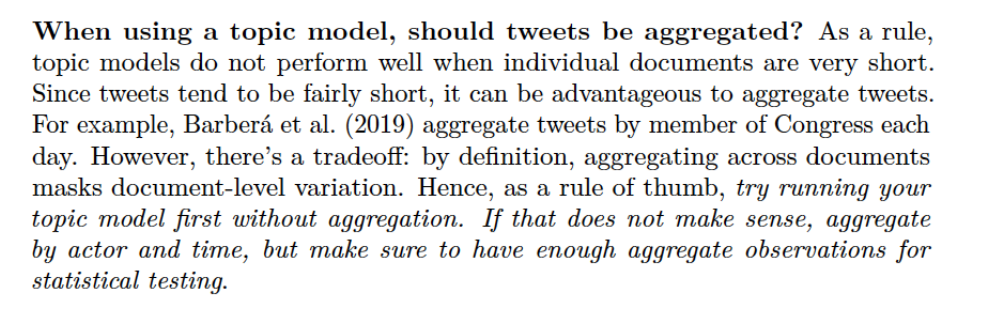

In [6]:
#I need to unpack the list in the dateframe so that they are just strings and not lists of words
tweets['corpus_lem'] = [' '.join(x) for x in tweets['text_lem']]

tweets['corpus_stem'] = [' '.join(x) for x in tweets['text_stem']]


In [34]:
#When running the model the first time,
#we found out that we need to exclude 'sanction' as this is already a sanctions related dataset
#so including the words only obscures the topics

#Removing 'sanction'
tweets['corpus_lem'] = [x.replace('sanction','') for x in tweets['corpus_lem']]

#Removing 'amp' (amp is a smiley which we deem not relevant for topics but perhaps for another analysis)
tweets['corpus_lem'] = [x.replace('amp','') for x in tweets['corpus_lem']]

#Removing 'russian' as it mainly next to 'russia'
tweets['corpus_lem'] = [x.replace('russian','') for x in tweets['corpus_lem']]


#Checking if it is removed
#tweets[tweets['corpus_stem'].str.contains('sanctions')]

#Logic for replacing                         
#text = text.replace(word, "")]


In [8]:
#Cutting of the minutes so that I only have the dates

tweets['date_time'] = tweets['date_time'].dt.date
tweets['date_time']

12        2022-02-25
54        2022-02-25
84        2022-02-25
105       2022-05-04
110       2022-05-04
             ...    
605904    2022-02-25
605945    2022-03-10
605946    2022-03-10
605963    2022-03-04
605983    2022-02-25
Name: date_time, Length: 19876, dtype: object

In [35]:
#Aggregating tweet data by dates and MEP
tweets_agg = tweets.groupby(['date_time', 'Name'], as_index = False).agg({'corpus_lem': ' '.join,
                                                                            'corpus_stem': ' '.join})
                                                                            #'clean_text': ' '.join,
                                                                            #'
                                                                            #'text_stem': ' '.join})
            
#Checking dimensions of new dataset and viewing the dataset
print(tweets_agg.shape)
tweets_agg.head()


(8879, 4)


,date_time,Name,corpus_lem,corpus_stem
0,2022-02-20,aldo patriciello,zelensky make potential russia public possibl...,zelenski make potenti russia public possibl i...
1,2022-02-20,andrea cozzolino,zelensky make potential russia public possibl...,zelenski make potenti russia public possibl i...
2,2022-02-20,angelo ciocca,zelensky make potential russia public possibl...,zelenski make potenti russia public possibl i...
3,2022-02-20,arnaud danjean,zelensky make potential russia public possibl...,zelenski make potenti russia public possibl i...
4,2022-02-20,billy kelleher,zelensky make potential russia public possibl...,zelenski make potenti russia public possibl i...


In [36]:
#Defining NLTK's TweetTokenizer
tokenizer = TweetTokenizer()

tqdm.pandas() #Creates a progress bar. Use progress_apply instead of apply.

#Creating a column of unigrams from the stemmed tweet text
tweets_agg['unigrams'] = tweets_agg['corpus_lem'].progress_apply(lambda x: tokenizer.tokenize(x))


100%|██████████| 8879/8879 [00:01<00:00, 7419.00it/s]


In [37]:
tweets_agg

,date_time,Name,corpus_lem,corpus_stem,unigrams
0,2022-02-20,aldo patriciello,zelensky make potential russia public possibl...,zelenski make potenti russia public possibl i...,"[zelensky, make, potential, russia, public, po..."
1,2022-02-20,andrea cozzolino,zelensky make potential russia public possibl...,zelenski make potenti russia public possibl i...,"[zelensky, make, potential, russia, public, po..."
2,2022-02-20,angelo ciocca,zelensky make potential russia public possibl...,zelenski make potenti russia public possibl i...,"[zelensky, make, potential, russia, public, po..."
3,2022-02-20,arnaud danjean,zelensky make potential russia public possibl...,zelenski make potenti russia public possibl i...,"[zelensky, make, potential, russia, public, po..."
4,2022-02-20,billy kelleher,zelensky make potential russia public possibl...,zelenski make potenti russia public possibl i...,"[zelensky, make, potential, russia, public, po..."
...,...,...,...,...,...
8874,2022-05-06,tonino picula,here go orban want money rrf drop veto oil emb...,here go orban want money rrf drop veto oil emb...,"[here, go, orban, want, money, rrf, drop, veto..."
8875,2022-05-06,urmas paet,adverse effect delay oil embargo russia advers...,advers effect delay oil embargo russia advers ...,"[adverse, effect, delay, oil, embargo, russia,..."
8876,2022-05-06,valter flego,adverse effect delay oil embargo russia advers...,advers effect delay oil embargo russia advers ...,"[adverse, effect, delay, oil, embargo, russia,..."
8877,2022-05-06,viola von cramon-taubadel,mep believe ukraine need assistance weapon ru...,mep believ ukrain need assist weapon russia and,"[mep, believe, ukraine, need, assistance, weap..."


In [38]:
#Defining a function that will create bigrams 
def bigrams(doc):
    
    bigrams = [] #Empty list to save the bigrams
    
    for bigram in list(nltk.bigrams(doc)):  #Creating bigrams and iterating over them
        bigrams.append("_".join(bigram))    #Connecting each bigram pair with an underscore and saving to list
    
    return bigrams

#Creating a column with bigrams
tweets_agg['bigrams'] = tweets_agg.unigrams.progress_apply(lambda x: bigrams(x))


100%|██████████| 8879/8879 [00:00<00:00, 65654.19it/s]


In [39]:
#Combining unigrams and bigrams in one column
tweets_agg['tokens'] = tweets_agg.unigrams+tweets_agg.bigrams

In [40]:
#Viewing new dataframe
tweets_agg.head(3)

,date_time,Name,corpus_lem,corpus_stem,unigrams,bigrams,tokens
0,2022-02-20,aldo patriciello,zelensky make potential russia public possibl...,zelenski make potenti russia public possibl i...,"[zelensky, make, potential, russia, public, po...","[zelensky_make, make_potential, potential_russ...","[zelensky, make, potential, russia, public, po..."
1,2022-02-20,andrea cozzolino,zelensky make potential russia public possibl...,zelenski make potenti russia public possibl i...,"[zelensky, make, potential, russia, public, po...","[zelensky_make, make_potential, potential_russ...","[zelensky, make, potential, russia, public, po..."
2,2022-02-20,angelo ciocca,zelensky make potential russia public possibl...,zelenski make potenti russia public possibl i...,"[zelensky, make, potential, russia, public, po...","[zelensky_make, make_potential, potential_russ...","[zelensky, make, potential, russia, public, po..."


In [41]:
#Viewing the tokens in the first row
print(tweets_agg.tokens[400])

['no', 'military', 'support', 'block', 'hardviest', 'possible', 'no', 'chance', 'stop', 'putin', 'shock', 'unfortunately', 'expect', 'attitude', 'deliver', 'germany', 'unfortunately', 'create', 'strong', 'interconnectednessdependencies', 'would', 'hit', 'u', 'well', 'but', 'price', 'pay', 'this', 'insidious', 'attack', 'putin', 'sovereign', 'european', 'country', 'devastate', 'effect', 'action', 'unacceptable', 'reprehensible', 'our', 'answer', 'harsh', 'we', 'show', 'president', 'eu', 'stand', 'united', 'people', 'ukraine', 'no_military', 'military_support', 'support_block', 'block_hardviest', 'hardviest_possible', 'possible_no', 'no_chance', 'chance_stop', 'stop_putin', 'putin_shock', 'shock_unfortunately', 'unfortunately_expect', 'expect_attitude', 'attitude_deliver', 'deliver_germany', 'germany_unfortunately', 'unfortunately_create', 'create_strong', 'strong_interconnectednessdependencies', 'interconnectednessdependencies_would', 'would_hit', 'hit_u', 'u_well', 'well_but', 'but_pri

### 2: Creating a corpus object

We will be using the `gensim` module to create a corpus object and filter very frequent and in-frequent words. Read the documentation here: https://radimrehurek.com/gensim/corpora/dictionary.html 

1. Create a dictionary mapping between words and their ids. This code is provided for you. This can take a couple of seconds.  
2. Use `filter_extremes` to remove very frequent (those that appear in more than 99.9% of the documents) and very infrequent words (those that appear in less than 10 documents).
3. You can inspect the vocabulary using either `id2token` or `token2id`. 
4. Create a corpus object. Essentially, use `doc2bow` in a list comprehension to create a list containing a bag of words for each document (aka for each row in the dataframe). Each bag of words should be a list containing tuples with 1) an index indicating the word and 2) the frequency of that word. The code could look like: `corpus = [id2word.doc2bow(doc) for doc in df['tokens']]`.


In [42]:
#Create a id2word dictionary

#Insert the column where you saved unigram and bigram tokens between the parentheses
id2word = Dictionary(tweets_agg['tokens']) 

#Viewing how many words are in our vocabulary
print(len(id2word))

20847


In [43]:
#Removing very frequent and infrequent words

#Dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=100000)
#remove very frequent (those that appear in more than 99.9% of the documents) 
#and very infrequent words (those that appear in less than 10 documents)


id2word.filter_extremes(no_below=10, no_above=.999, keep_n = None)
print(len(id2word))


8876


In [44]:
#Uncomment to see the full vocabulary

for i, token in enumerate(id2word.token2id.keys()):
    print (i,token)

0 cnn
1 invasion
2 invasion_cnn
3 make
4 make_potential
5 possible
6 possible_invasion
7 potential
8 potential_russia
9 public
10 public_possible
11 russia
12 russia_public
13 zelensky
14 zelensky_make
15 2
16 2_expel
17 asset
18 asset_oligarch
19 coal
20 coal_scrap
21 diplomat
22 diplomat_freeze
23 expel
24 expel_diplomat
25 freeze
26 freeze_asset
27 gas
28 gas_oil
29 if
30 nord
31 nord_stream
32 oil
33 oil_coal
34 oligarch
35 oligarch_if
36 scrap
37 scrap_nord
38 stream
39 stream_2
40 traczyk
41 traczyk_gas
42 agreement
43 ally
44 eu
45 eu_need
46 firm
47 international
48 international_law
49 law
50 minsk
51 minsk_agreement
52 need
53 react
54 react_swift
55 recognition
56 separatist
57 solidarity
58 solidarity_ukraine
59 swift
60 territory
61 the
62 the_eu
63 together
64 two
65 ukraine
66 unity
67 violation
68 act
69 act_recognise
70 breach
71 breach_international
72 clear
73 clear_statement
74 donesk
75 donesk_remain
76 economical
77 economical_military
78 eu_impose
79 full
80 full

885 boycott
886 could
887 extend
888 flight
889 further
890 may
891 million
892 mind
893 must_stop
894 something
895 we_must
896 for
897 poland
898 scholz
899 aggression_must
900 democracy
901 eu_adopt
902 freedom
903 freedom_democracy
904 independent
905 putin_aggression
906 with
907 1_very
908 5_top
909 act_decisive
910 active
911 active_participant
912 aho
913 aho_i
914 alternative
915 alternative_import
916 aslund
917 aslund_summary
918 at
919 at_point
920 bank_restrict
921 banking
922 banking_oil
923 bidens
924 bidens_today
925 broad
926 broad_go
927 buy_oil
928 challenge
929 challenge_role
930 closing
931 closing_russia
932 core
933 core_economy
934 crime
935 crime_the
936 criminal
937 criminal_war
938 czech
939 czech_president
940 decisive_broad
941 dependency_oilgas
942 difficult
943 difficult_active
944 disconnect
945 disconnect_russia
946 do_buy
947 drastically
948 drastically_limit
949 economy_powerfinancing
950 effective
951 effective_invest
952 elsewhereputins
953 elsewher

1635 russia_include
1636 urge
1637 argument
1638 please
1639 serious
1640 also_need
1641 back_dark
1642 draw
1643 energy_union
1644 facility
1645 launch
1646 peace_facility
1647 stability
1648 must_face
1649 need_help
1650 tribunal
1651 ukraine_it
1652 urgent
1653 war_war
1654 president_the
1655 support_strong
1656 chancellor
1657 former
1658 russi
1659 schroeder
1660 harder
1661 just
1662 meeting
1663 situation
1664 situation_ukraine
1665 summit
1666 exclude_swift
1667 payment
1668 payment_system
1669 russia_exclude
1670 swift_payment
1671 finland
1672 alter
1673 less
1674 tool
1675 brutal
1676 targeted
1677 totally
1678 challenge_we
1679 funding
1680 innocent_people
1681 value
1682 value_freedom
1683 day
1684 moscow
1685 the_must
1686 benefit
1687 line
1688 think
1689 dualuse
1690 eu_target
1691 g
1692 sector
1693 aid
1694 citizen
1695 effort
1696 humanitarian
1697 humanitarian_aid
1698 institution
1699 make_putin
1700 must_come
1701 side
1702 sovereign_democratic
1703 ukraine_we
170

2384 ukraine_get
2385 ukraine_http
2386 unianimously
2387 unianimously_should
2388 via_cips
2389 vote_instead
2390 we_weak
2391 weak_impose
2392 wide
2393 wide_rangingindividual
2394 yet_the
2395 energy_sector
2396 figure
2397 month
2398 reverse
2399 reverse_ban
2400 ban_sale
2401 go_even
2402 support_ban
2403 confirm
2404 favour
2405 french
2406 align
2407 align_rest
2408 antiwar
2409 assistance
2410 carveouts
2411 carveouts_italys
2412 chigi
2413 chigi_italy
2414 discuss
2415 eu_ukr
2416 fully_align
2417 italy_make
2418 italys
2419 italys_position
2420 make_request
2421 position_fully
2422 request
2423 request_carveouts
2424 rest
2425 rest_eu
2426 ukr
2427 act_fast
2428 but_exclude
2429 euco_act
2430 fact
2431 fact_euco
2432 fast_russia
2433 good_thing
2434 russia_good
2435 swift_be
2436 the_fact
2437 thing_but
2438 blood
2439 fuel
2440 putin_force
2441 soldier
2442 aggression_uk
2443 del
2444 del_sistema
2445 europa
2446 europa_kick
2447 expulsemos
2448 expulsemos_rusia
2449 need_st

3371 billions_dollar
3372 but_one
3373 carnegie
3374 carnegie_moscow
3375 centre
3376 centre_thus
3377 crucially
3378 crucially_theyre
3379 cut_lender
3380 dmitri
3381 dmitri_trenin
3382 dollar
3383 dollar_but
3384 economic_tie
3385 face_may
3386 germany_big
3387 head_carnegie
3388 hidden
3389 hidden_htt
3390 htt_today
3391 interest_economic
3392 know_true
3393 leader_put
3394 lender
3395 lender_swift
3396 look
3397 look_pm
3398 lose_next
3399 lose_russia
3400 may_billions
3401 moscow_centre
3402 next_nothing
3403 nothing_western
3404 one_know
3405 power_real
3406 putin_face
3407 real_substantial
3408 russia_central
3409 russia_unlike
3410 say_dmitri
3411 still_look
3412 substantial
3413 substantial_interest
3414 swift_crucially
3415 the_vladimir
3416 theyre
3417 theyre_still
3418 thus
3419 thus_lose
3420 tie_russia
3421 today_germany
3422 trenin
3423 trenin_head
3424 true_wealth
3425 uk_lose
3426 unlike
3427 unlike_u
3428 wealth_hidden
3429 western_leader
3430 western_power
3431 addit

3884 year_freund
3885 but_rest
3886 democracy_full
3887 dsa
3888 embargo_necessary
3889 eu_stop
3890 fight_life
3891 finance_mad
3892 freedom_shame
3893 full_oil
3894 gas_buy
3895 google
3896 google_wont
3897 income
3898 income_west
3899 lie_ukrainans
3900 life
3901 life_freedom
3902 mad
3903 mad_war
3904 make_money
3905 money
3906 money_lie
3907 necessary_eu
3908 payment_oil
3909 propaganda_but
3910 putin_use
3911 rest_world
3912 shame_standingwithukraine
3913 standingwithukraine
3914 standingwithukraine_ukrainekrieg
3915 stop_make
3916 stop_propaganda
3917 tank_finance
3918 ukrainans
3919 ukrainans_fight
3920 ukraine_democracy
3921 ukrainekrieg
3922 ukrainekrieg_zelenskiy
3923 use_income
3924 west_payment
3925 world_google
3926 zelenskiy
3927 zelenskiy_dsa
3928 aftermath
3929 aftermath_russia
3930 agency_international
3931 assistance_ukraine
3932 call_even
3933 cooperation_un
3934 demand_tough
3935 dsa_en
3936 eg
3937 eg_trade
3938 embargo_emergency
3939 emergency_humanitarian
3940 e

4884 minister_finance
4885 national
4886 national_currencystop
4887 officially_back
4888 putin_fifth
4889 russia_minister
4890 stop_act
4891 the_hungarian
4892 varga
4893 varga_blame
4894 after_eu
4895 censorship
4896 censorship_country
4897 censorship_regime
4898 country_draconian
4899 degree
4900 degree_there
4901 disarm
4902 disarm_information
4903 draconian
4904 draconian_degree
4905 eu_censorship
4906 freedom_informationread
4907 information_war
4908 informationread
4909 informationread_more
4910 internet
4911 internet_press
4912 need_disarm
4913 press_censorship
4914 regime_tighten
4915 restore
4916 restore_freedom
4917 talk_after
4918 there_urgent
4919 tighten
4920 tighten_internet
4921 war_restore
4922 act_implement
4923 american
4924 american_position
4925 dissolve
4926 government_italy
4927 idea
4928 idea_ukraine
4929 implement_idea
4930 india
4931 india_american
4932 italy_please
4933 pacific
4934 pacific_dissolve
4935 please_act
4936 position_pacific
4937 the_government
493

5883 existential
5884 existential_putin
5885 ignore_existential
5886 putin_threat
5887 seem_already
5888 threat_dont
5889 waver
5890 waver_europe
5891 weapon_waver
5892 150
5893 150_billion
5894 ban_tchaikovsky
5895 bentall
5896 bentall_the
5897 big_export
5898 billion_russia
5899 cash
5900 cash_help
5901 could_simply
5902 darkness
5903 dependent_mean
5904 eu_darkness
5905 euuk
5906 euuk_spent
5907 export_that
5908 fund_militarywar
5909 gasoil
5910 gasoil_russia
5911 harder_eu
5912 help_fund
5913 machinefurthermore
5914 machinefurthermore_dependent
5915 mean_harder
5916 militarywar
5917 militarywar_machinefurthermore
5918 next_theyll
5919 put_eu
5920 russia_big
5921 russia_could
5922 russia_gasoil
5923 simply_turn
5924 spent
5925 spent_150
5926 supply_put
5927 tchaikovsky
5928 tchaikovsky_bentall
5929 that_cash
5930 the_euuk
5931 theyll
5932 theyll_ban
5933 turn_supply
5934 10_eu
5935 eu_tradewith
5936 orange
5937 orange_10
5938 poland_propose
5939 propose_totally
5940 russia_via
5941 

6755 forward_visit
6756 honour
6757 honour_putin
6758 leader_enter
6759 look_forward
6760 meps_eu
6761 promise_putin
6762 putin_blacklist
6763 russia_thank
6764 thank_honour
6765 visit_ukraine
6766 eu_exc
6767 exc
6768 innovation_poland
6769 late_pl
6770 during
6771 coal_grain
6772 commodity
6773 commodity_oil
6774 embargo_commodity
6775 evolve
6776 evolve_indirect
6777 indirect
6778 indirect_embargo
6779 might_evolve
6780 this_might
6781 bring_ukrain
6782 corrupt_political
6783 crisis_result
6784 gas_crisis
6785 german_gas
6786 germany_turn
6787 inaction_the
6788 interest_germany
6789 leader_treat
6790 long_ago
6791 negligence
6792 negligence_corrupt
6793 nordstream_nostream
6794 nostream
6795 nostream_long
6796 political_interest
6797 political_negligence
6798 result_long
6799 smokescreen
6800 smokescreen_inaction
6801 suppose_bring
6802 term_political
6803 the_suppose
6804 treat_smokescreen
6805 turn_nordstream
6806 ukrain_german
6807 circumvent_eu
6808 no_surprise
6809 surprise
681

7576 majority_hear
7577 massively
7578 massively_european
7579 parliament_adopts
7580 parliamentsha
7581 parliamentsha_it
7582 round_putins
7583 see_late
7584 voice_european
7585 vote_full
7586 embargo_break
7587 nuclear_how
7588 adopt_vital
7589 allow_financing
7590 almost_1
7591 ban_proud
7592 co_finally
7593 coal_thats
7594 continue_pay
7595 day_gas
7596 en_strong
7597 euro_every
7598 finally_today
7599 gas_petrol
7600 import_of
7601 not_allow
7602 of_we
7603 pay_almost
7604 petrol
7605 petrol_coal
7606 proud_todays
7607 resolutionmeps
7608 resolutionmeps_vote
7609 strong_position
7610 thats_vote
7611 todays_en
7612 vital_resolutionmeps
7613 war_continue
7614 0203
7615 0203_100
7616 100_per
7617 2022_include
7618 2425
7619 2425_march
7620 accord_french
7621 adultper
7622 adultper_yearmanageable
7623 against_russia
7624 aginst
7625 aginst_ukraine
7626 average
7627 average_feasible
7628 ban_fossil
7629 capitaeu
7630 capitaeu_adultper
7631 complete_eu
7632 conclusion_european
7633 cons

8356 rapporteur_this
8357 spacs
8358 spacs_opposition
8359 support_now
8360 surveillance_public
8361 this_need
8362 u_support
8363 war_miss
8364 also_commitment
8365 aspire
8366 aspire_join
8367 avoidance_also
8368 business_leader
8369 commitment_country
8370 country_aspire
8371 country_european
8372 deal_individual
8373 eu_deal
8374 european_future
8375 if_indeed
8376 indeed_true
8377 individual_eu
8378 leader_country
8379 list_raise
8380 political_business
8381 possible_avoidance
8382 question_possible
8383 raise
8384 raise_serious
8385 serious_question
8386 true_political
8387 deal_enables
8388 enables
8389 enables_germany
8390 germany_join
8391 germany_poland
8392 join_oil
8393 poland_strike
8394 strike_deal
8395 the_r
8396 thread_the
8397 body_russias
8398 chancellor_prime
8399 corporation_like
8400 corruptionmedice
8401 corruptionmedice_cura
8402 cura
8403 cura_te
8404 earn
8405 earn_money
8406 energy_corporation
8407 france_earn
8408 france_selling
8409 gazprom
8410 gazprom_nord

In [45]:
#Creating a corpus object 

corpus = [id2word.doc2bow(doc) for doc in tweets_agg['tokens']]


### 3: Topic modelling

We will run topic modelling using an LDA implementation from the `gensim` module. You can find the documentation here: https://radimrehurek.com/gensim/models/ldamulticore.html 

We will investigate the results of a model with 50 topics. However, this takes several hours to run. Therefore, first try the LDA algorithm with approx. 10 topics and then download the pre-trained model to investigate the 50-topic results.

1. Run the LDA algorithm with the provided code
2. The typical way to get a sense of what each topic actually is means looking at the tokens that are most predictive for each topic. Use `print_topics` to see the 10 (or more) most predictive tokens for each topic. Optional: When using `print_topics`, the model weights are included. If you want to clean this, you can use regex to filter out everything but the words.


**A note on setting parameters:**

- Passes and iterations: As this is just a test run, passes and iterations are set quite low. If you want to use topic modelling in your project, you should make sure to set passes and iterations high enough for the model to converge. In the pre-trained model, passes = 100 and iterations = 1000. 
- Minimum_probability: This filters out all probabilities less than the given number. In the pre-trained model, minimum_probability = 0.000001


**A note on choosing the number of topics:**
Choosing the number of topics is not straightforward. Both Barberá (2019) and Munger (2019) use 10-fold cross-validation for the log-likelihood and perplexity. If you want to implement these models in your own work and want to learn how to do this, read about hyperparameter tuning [here](https://towardsdatascience.com/twitter-topic-modeling-e0e3315b12e2) or contact Greg who can guide you in R. 

At the same time, there is no statistic that can tell you how many topics you want: "There is often a negative relationship between the best-fitting model and the substantive information provided" (Grimmer and Stewart 2013). So in the end it is a judgment call on the side of the researcher, which can be guided by statistics.

If topics repeat themselves, this may suggest that we chose too many topics for the dataset. 


# We tried 50, 20 and landed at 15 topics

In [46]:
#Instantiating a logger to get information on the progress of the LDA
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

#Running the LDA with 10 topics 
lda_model = LdaMulticore(corpus=corpus, num_topics=15, id2word=id2word, passes = 1, iterations = 50)


In [47]:
#Disabling logging again
logging.disable(sys.maxsize)

In [48]:
#Finding the 10 most predictive tokens for each topic

#Using regex to filter the words from the weights 
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda_model.print_topics(20,10)]


In [49]:
# Printing the topics in a nice format
for id, t in enumerate(words): 
    print(f"------ Topic {id} ------")
    print(' '.join(t), end="\n\n")
    

------ Topic 0 ------
russia eu war ban support swift ukraine embargo energy call

------ Topic 1 ------
russia ukraine oil gas germany eu putin support embargo stop

------ Topic 2 ------
eu russia must putin the ukraine war ban work full

------ Topic 3 ------
eu war ukraine putin the oil also russia stop embargo

------ Topic 4 ------
eu russia putin ukraine swift war we need ban i

------ Topic 5 ------
eu russia ban putin war the must oil ukraine embargo

------ Topic 6 ------
eu call putin embargo ban import russia the oil full

------ Topic 7 ------
embargo eu russia gas european immediate oil ban full war

------ Topic 8 ------
russia eu war ban ukraine oil the today stop putin

------ Topic 9 ------
russia eu putin swift war ukraine must we ban i

------ Topic 10 ------
russia eu the embargo gas oil ukraine ban war call

------ Topic 11 ------
eu embargo gas oil russia full ban putin call import

------ Topic 12 ------
eu russia embargo the oil putin ban full call war

------ 

In [18]:
#Code for saving the models

#path = #to the folder in which you want the models saved

#pickle.dump(base_model, open(path+'ldamodel.sav', 'wb'))
#pickle.dump(corpus, open(path+'corpus.sav', 'wb'))
#pickle.dump(id2word, open(path+'id2word.sav', 'wb'))

### 4.1: Investigating results: beta parameters

To investigate the results, load the pre-trained models with the provided code. 

Retrieve the estimated **beta parameters** from the model. There is a beta per token per topic. A beta indicates how predictive a token is of a document being assigned to a specific topic. 

1. Beta values can be accessed using either `get_topic_terms` (where you input the topic and number of most predictive tokens you want returned) or `get_topics` (which returns the full matrix of beta values). 
2. Pick two or three topics (in the solution code the topics 1, 8, 16, 27, 28, 29, 31, 41, 47, 48 were chosen for visualization). Get the 10 highest beta values and plot these in a horizontal barchart with `sns.barplot`, where x is the beta probability and y is the token. 

Hint: Create a dataframe from the matrix generated by `get_topics` with token names as the column names. Tokens can be retrieved with the `id2word.token2id`. Once you have the dataframe, `nlargest` can be used on a specific row to get the columns with the *n* largest values in that row. 

Intended take-away: The "top terms" for each topic are just the tokens that have the largest beta. 


# We will not import the model as we made our own model above

In [19]:
#Importing the pre-trained models 

#lda_model=pickle.load(open('ldamodel_50t100p1000i000001minprob.sav', 'rb'))
#corpus=pickle.load(open('corpus_50t100p1000i000001minprob.sav', 'rb'))
#id2word=pickle.load(open('id2word_50t100p1000i000001minprob.sav', 'rb'))


In [20]:
#Uncomment to inspect the vocabulary 

#id2word.id2token

In [50]:
#In the following solution, get_topics() was used to find and visualize beta values 
#get_topic_terms is an alternative that could also have been used.

#Returns (Word ID, probability) pairs for the most relevant words generated by the topic

lda_model.get_topic_terms(14,10) #This returns the 10 words that are most significant for topic 20


[(11, 0.015050082),
 (32, 0.014144879),
 (44, 0.010599847),
 (1237, 0.010243345),
 (835, 0.009942961),
 (27, 0.008938374),
 (61, 0.008114834),
 (733, 0.007232411),
 (65, 0.00672474),
 (104, 0.0065056095)]

In [51]:
#Viewing the shape of base_model.get_topics() to verify that the shape is (topics, tokens)

#It is different from above since the first model is only trained on 10 topics while the pret

lda_model.get_topics().shape


(15, 8876)

In [52]:
#Creating a dataframe with tokens as columns and topics as rows 

#token2id gets all tokens and their associated id. list(id2word.token2id.keys()) creates a list of just the tokens. 

beta_df = pd.DataFrame(lda_model.get_topics(), columns = list(id2word.token2id.keys()))


In [53]:
#Viewing the dataframe

beta_df.head()

,cnn,invasion,invasion_cnn,make,make_potential,possible,possible_invasion,potential,potential_russia,public,...,must_pull,nuclear_energyrussia,pull_controversial,rely_upon,rosatom_see,see_contribution,stress_importance,upon_hungary,widen_include,russia_adverse
0,0.000005,0.001798,0.000005,0.000593,0.000005,0.000386,0.000005,0.000017,0.000005,0.000333,...,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005
1,0.000002,0.001276,0.000002,0.001628,0.000002,0.000903,0.000002,0.000002,0.000002,0.000237,...,0.000069,0.000095,0.000081,0.000080,0.000078,0.000071,0.000092,0.000106,0.000094,0.000058
2,0.000003,0.000434,0.000003,0.000942,0.000003,0.000311,0.000003,0.000003,0.000003,0.000227,...,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000023
3,0.000003,0.000658,0.000003,0.004450,0.000003,0.000139,0.000003,0.000003,0.000003,0.000179,...,0.000154,0.000184,0.000178,0.000231,0.000194,0.000200,0.000207,0.000224,0.000135,0.000003
4,0.000003,0.000849,0.000003,0.001108,0.000003,0.000640,0.000003,0.000003,0.000003,0.000062,...,0.000324,0.000306,0.000321,0.000356,0.000340,0.000352,0.000302,0.000292,0.000262,0.000003


In [56]:
#Uncomment to see the 10 words with the largest beta values for each topic 

for i in range(15): 
    print(beta_df.iloc[i].nlargest(10),"\n___\n")

#A note on the results: You may notice that some topics have an even distributions of probabilities for all terms. 
#This may be because the `minimum_probability` parameter is not low enough, 
#    because we do not have enough `passes` and `iterations` and the algorithm has thus not converged properly, 
#    or because we have set the number of topics too high for the data. 
#    For your own projects, experiment with the parameters. 



#Topics:
#Natural resources
#Trade
#Putin
#Russia
#War

#What can we do?
# 1) Exclude more words? No

# 2) Can we do it in rounds? so first detect energy then remove. Now, another round and detect new topics? No




# 3) Try it with new model instead of LDA : https://pypi.org/project/topsbm/ (snorre and hjalmar)

# 4) Find new topics

# 5) run the new FFN using this : https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24


russia     0.021881
eu         0.017341
war        0.005743
ban        0.005113
support    0.003742
swift      0.003674
ukraine    0.003423
embargo    0.003357
energy     0.003345
call       0.003280
Name: 0, dtype: float32 
___

russia     0.010259
ukraine    0.008739
oil        0.008341
gas        0.008102
germany    0.007798
eu         0.007372
putin      0.006605
support    0.006269
embargo    0.006184
stop       0.005796
Name: 1, dtype: float32 
___

eu         0.012744
russia     0.008069
must       0.008011
putin      0.007786
the        0.006982
ukraine    0.006178
war        0.006160
ban        0.005542
work       0.004872
full       0.004400
Name: 2, dtype: float32 
___

eu         0.013044
war        0.012296
ukraine    0.008391
putin      0.008338
the        0.008197
oil        0.006450
also       0.006397
russia     0.006001
stop       0.005766
embargo    0.005103
Name: 3, dtype: float32 
___

eu         0.013434
russia     0.011342
putin      0.007572
ukraine    0.006534


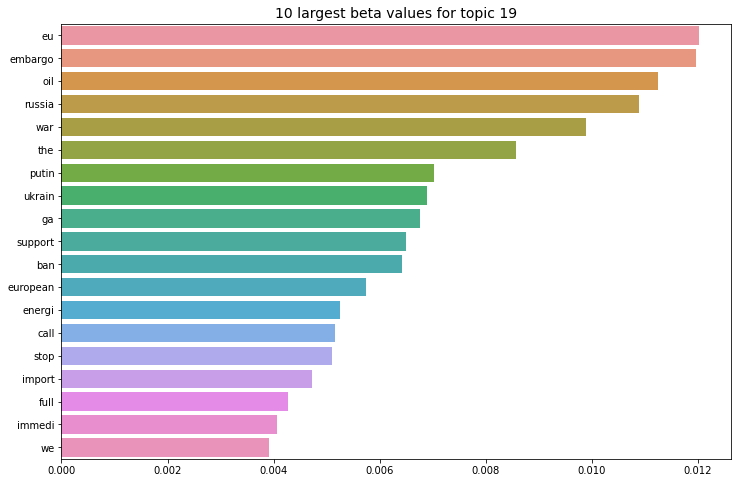

In [169]:
#Visualizing topic 41

#beta_df.iloc[41].nlargest(10) locates the 10 largest values in row 41. 
# .values returns the beta values
# .index returns the words

plt.figure(figsize = (12,8))

ax = sns.barplot(x = beta_df.iloc[10].nlargest(19).values, 
                 y = beta_df.iloc[10].nlargest(19).index, 
                 orient = 'h')

plt.title('10 largest beta values for topic 19', fontsize = 14)
plt.show()

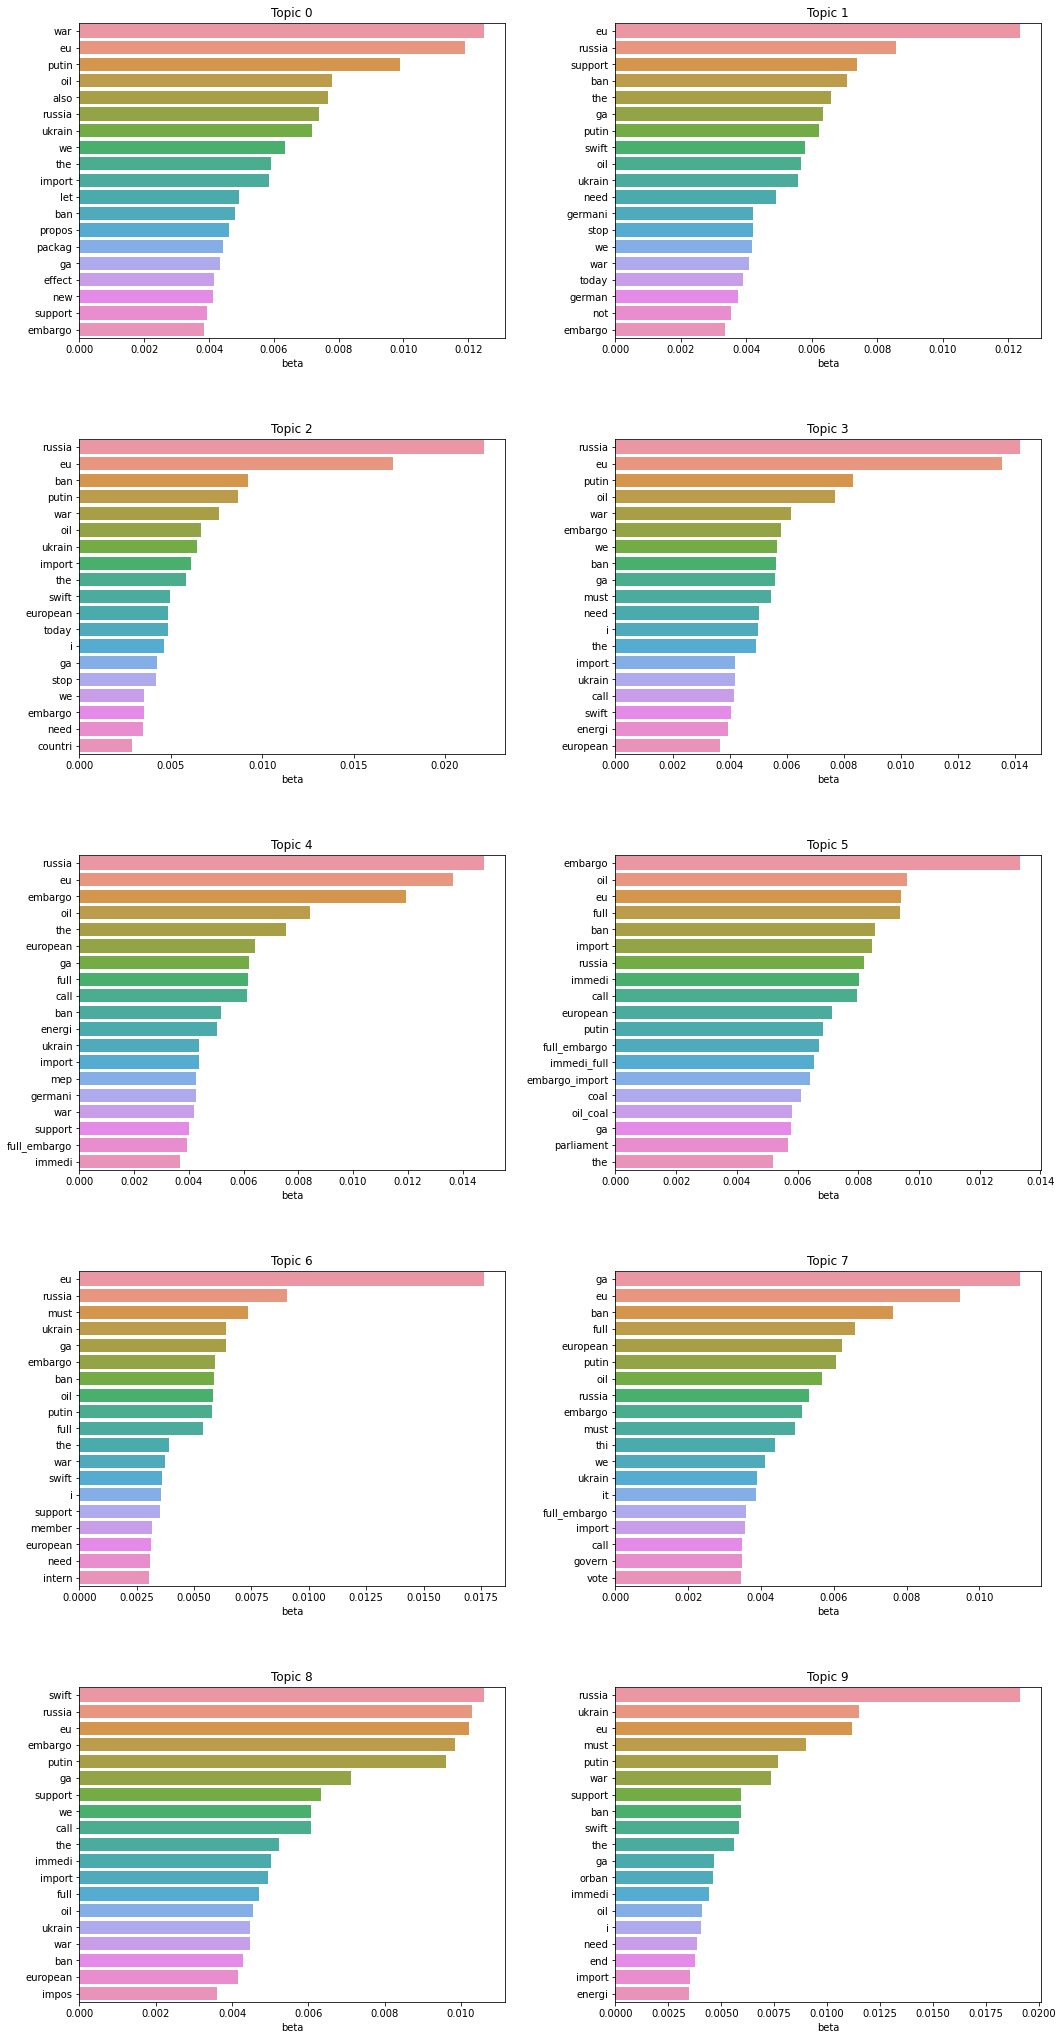

In [170]:
#Visualizing first 10 topics
topics = [i for i in range(10)]

fig, axes = plt.subplots(ncols=2, nrows=5, figsize = (16,30)) #Setting 10 subplots and determining figure size
fig.tight_layout(pad=8.0) #This ensure space between the subplots so the text can more easily be read
    
for ax, topic in zip(axes.flatten(), topics): #Iterates through the axes and the topics
    
    #Creates 10 barplots with x as the beta values and y as the words
    sns.barplot(ax = ax, 
                x = beta_df.iloc[topic].nlargest(19).values, 
                y = beta_df.iloc[topic].nlargest(19).index, 
                orient = 'h')
    
    ax.set(title='Topic {}'.format(topic), xlabel='beta')

plt.show()


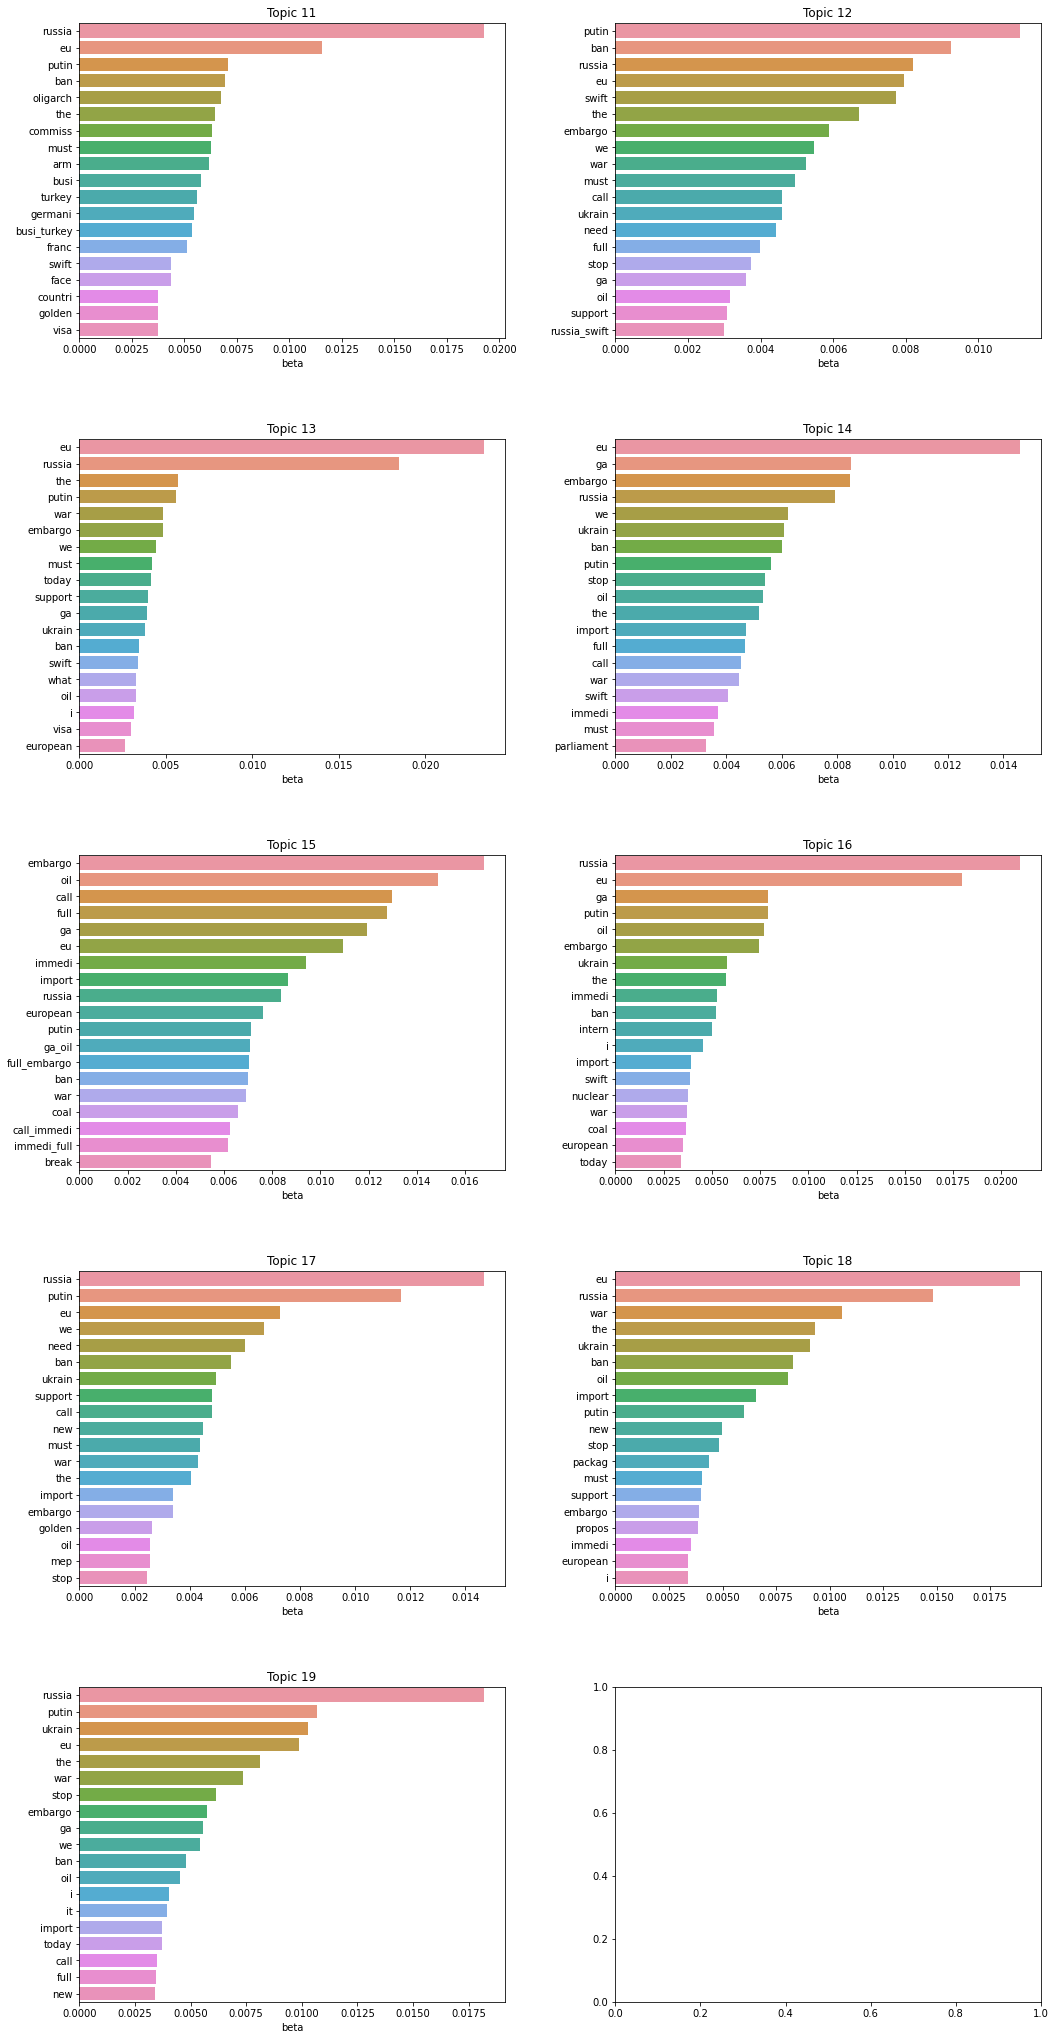

In [171]:
#Visualizing last topics
topics = [11,12,13,14,15,16,17,18,19]

fig, axes = plt.subplots(ncols=2, nrows=5, figsize = (16,30)) #Setting 10 subplots and determining figure size
fig.tight_layout(pad=8.0) #This ensure space between the subplots so the text can more easily be read
    
for ax, topic in zip(axes.flatten(), topics): #Iterates through the axes and the topics
    
    #Creates 10 barplots with x as the beta values and y as the words
    sns.barplot(ax = ax, 
                x = beta_df.iloc[topic].nlargest(19).values, 
                y = beta_df.iloc[topic].nlargest(19).index, 
                orient = 'h')
    
    ax.set(title='Topic {}'.format(topic), xlabel='beta')

plt.show()

### 4.2: Investigating results: gamma parameters

Retrieve the estimated **gamma parameters** from the model. For each document, you will get a list of topics with an associated gamma. The gammas indicate the probability (or amount) that a document is about a specific topic.

1. Use `get_document_topics` with the full corpus to get lists of probabilities for each document.
2. Save the probabilities in the original dataframe. You can find inspiration for how to do this in this pseudo-code:

**Pseudo-code to save the probabilities in the original dataframe:**

Use list comprehension to create a list of 50 topic names (e.g. topic_1, topic_2 etc.)

Create a dataframe filled with zeros of the shape (number of documents - 864, number of topics - 50) and with columns = the list of 50 topic names. 

For each index, document in the list of gamma probabilities: <br>
<font color=white>0000</font>for each topic-probability pair in the document: <br>
<font color=white>00000000</font>locate index and column with that topic name and save the probability

Concatenate this dataframe with the original dataframe over axis 1.



In [28]:
#Insert the corpus of documents in bag of word format and get an array of (document, topic, probability). 

import numpy as np

document_topics = np.array(lda_model.get_document_topics(corpus, minimum_probability=0.0)) 


In [33]:
#document_topics

In [30]:
#Uncomment to view gamma values for the first document

#print(document_topics.shape)
#document_topics[0]


In [31]:
#Creating a list of names for all 50 topics
topics = ['topic_{}'.format(t) for t in range(0,50)]

#Creating a dataframe of gamma probabilities 
gamma_probs = pd.DataFrame(document_topics[:,:,1], columns = topics)

In [32]:
#Merging with the original dataframe 
gamma_df = pd.concat((tweets_agg,gamma_probs), axis = 1)

#Viewing the concatenated dataframe
gamma_df.head()

,date,affiliation,text,text_lemma,text_stemmed,unigrams,bigrams,tokens,topic_0,topic_1,...,topic_40,topic_41,topic_42,topic_43,topic_44,topic_45,topic_46,topic_47,topic_48,topic_49
0,2019-01-01,Democrat,"Out of a tragedy, some great news: with the Pr...",tragedy great news president signature tonight...,tragedi great news presid signatur tonight #as...,"[tragedi, great, news, presid, signatur, tonig...","[tragedi_great, great_news, news_presid, presi...","[tragedi, great, news, presid, signatur, tonig...",4.003597e-06,4.003597e-06,...,0.000004,4.003597e-06,4.003597e-06,4.003597e-06,0.116614,4.003597e-06,4.003597e-06,4.003597e-06,4.003597e-06,4.003597e-06
1,2019-01-01,Republican,"Have a happy, healthy and prosperous 2019! #H...",happy healthy prosperous #happynewyear # k #ne...,happi healthi prosper #happynewyear # k #newye...,"[happi, healthi, prosper, #happynewyear, #, k,...","[happi_healthi, healthi_prosper, prosper_#happ...","[happi, healthi, prosper, #happynewyear, #, k,...",9.801448e-06,9.801448e-06,...,0.000010,9.801448e-06,9.801448e-06,9.801448e-06,0.207758,9.801448e-06,9.801448e-06,9.801448e-06,9.801448e-06,9.801448e-06
2,2019-01-02,Democrat,Amen. https://t.co/fiM7C8e4lc “My supervisor t...,amen supervisor tell wont get pay bill wont ge...,amen supervisor told wont get paid bill wont g...,"[amen, supervisor, told, wont, get, paid, bill...","[amen_supervisor, supervisor_told, told_wont, ...","[amen, supervisor, told, wont, get, paid, bill...",2.251315e-06,2.251315e-06,...,0.000002,2.251315e-06,2.251315e-06,2.251315e-06,0.001989,2.251315e-06,2.251315e-06,2.251315e-06,2.251315e-06,2.251315e-06
3,2019-01-02,Republican,RT @cdw: I see that Mr. Alright Alright Alrigh...,see mr alright alright alright sideline #hooke...,see mr alright alright alright sidelin #hookem...,"[see, mr, alright, alright, alright, sidelin, ...","[see_mr, mr_alright, alright_alright, alright_...","[see, mr, alright, alright, alright, sidelin, ...",5.221434e-06,5.221434e-06,...,0.000005,5.221434e-06,5.221434e-06,5.221434e-06,0.003443,5.221434e-06,5.221434e-06,5.221434e-06,5.221434e-06,5.587973e-01
4,2019-01-03,Democrat,"Before the shutdown, before the pay freeze, th...",shutdown pay freeze federal government suffer ...,shutdown pay freez feder govern suffer lack le...,"[shutdown, pay, freez, feder, govern, suffer, ...","[shutdown_pay, pay_freez, freez_feder, feder_g...","[shutdown, pay, freez, feder, govern, suffer, ...",9.559949e-07,9.559949e-07,...,0.162080,9.559949e-07,9.559949e-07,9.559949e-07,0.000888,9.559949e-07,9.559949e-07,9.559949e-07,9.559949e-07,9.559949e-07


### 5: Visualizing the development of the coronavirus related topic 

Getting back to the original question: How has the topic of coronavirus progressed on Twitter among Members of Congress over time? 

1. Use `print_topics` to look through the 10 most relevant words of each topic and identify the topic related to coronavirus. 
2. If it is not already, convert the date column from string type to datetime type
3. Graph the development of the coronavirus topic over time. Create a plot where x = date, y = the covid topic, and hue = affiliation. 
4. Do the same with a subset of the dataset only including 2020. 

Can you see which party was quicker to set the agenda around COVID-19? 


In [34]:
#Using regex to find all words and filter them from the weights
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda_model.print_topics(50,10)]

# Printing the topics in a nice format
for id, t in enumerate(words): 
    print(f"------ Topic {id} ------")
    print(' '.join(t), end="\n\n")
    
#Topic 41 is coronavirus


------ Topic 0 ------
internet_open introduc_war intermediate-rang_nuclear intern_agreement internet_continu internet_free interest_attend intimid_us invit_help invest_act

------ Topic 1 ------
cut budget #trumpbudget trump presid medicar propos medicaid women program

------ Topic 2 ------
trump protect im need famili health commun vote act hous

------ Topic 3 ------
border secur democrat job nation govern - congress presid continu

------ Topic 4 ------
hous trump presid fight need women vote protect support act

------ Topic 5 ------
labor worker #laborday labor_day #dorian famili day union right wage

------ Topic 6 ------
new tax new_year job happi_new famili peopl wage first -

------ Topic 7 ------
vote war right act iran congress hous pass trump must

------ Topic 8 ------
wish celebr famili christma holiday merri peac merri_christma love may

------ Topic 9 ------
constitut happi lewandowski birthday nd usairforc nd_birthday happi_nd document air

------ Topic 10 ------
impe

In [35]:
#Converting date from str type to datetime type
gamma_df['date'] = pd.to_datetime(gamma_df['date'])

In [49]:
#Uncomment to see all probabilities for the covid topic 

for prob in gamma_df['topic_41']:
    print(prob)

4.003597496193834e-06
9.801447959034704e-06
2.2513149815495126e-06
5.22143409398268e-06
9.559948921378236e-07
1.918317821036908e-06
7.278308657987509e-07
1.597122491148184e-06
2.4758526251389412e-06
5.699153916793875e-06
2.6220682229904924e-06
6.797603418817744e-06
1.298758206758066e-06
2.4043702069320716e-06
7.094742500157736e-07
2.252938202218502e-06
4.6400472797358816e-07
9.98137238639174e-07
6.309513764790609e-07
1.4942023653929937e-06
7.647241773156566e-07
1.7118708228736068e-06
1.8121108951163478e-06
4.964495019521564e-06
2.544232074797037e-06
6.812491392338416e-06
1.1823057093351963e-06
2.6430720936332364e-06
6.689116389679839e-07
1.7271917158723227e-06
6.186397172314173e-07
1.4187810393195832e-06
6.962068255234044e-07
1.586600546943373e-06
8.182548185686755e-07
1.765823640198505e-06
1.4908671346347546e-06
2.9592183636850677e-06
2.031416215686477e-06
6.473082976299338e-06
1.2943327192260767e-06
2.6553527732176008e-06
7.9410295938942e-07
2.5285305582656292e-06
7.834810844542517e-

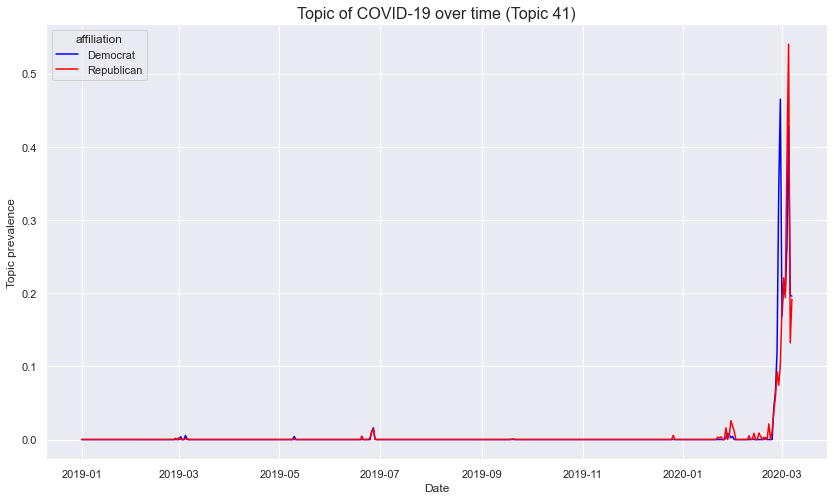

In [50]:
#Setting a theme
sns.set_theme(style="darkgrid")

#Plotting a figure and setting figure size
plt.figure(figsize = (14,8))

#Choosing colors
palette = ['blue','red'] 

#Plotting the covid topic for the full dataset
sns.lineplot(x = 'date', y = 'topic_41', hue = 'affiliation', data = gamma_df, palette = palette)

plt.title('Topic of COVID-19 over time (Topic 41)', fontsize = 16)
plt.ylabel('Topic prevalence')
plt.xlabel('Date')

plt.show()

#So, the democrats were faster

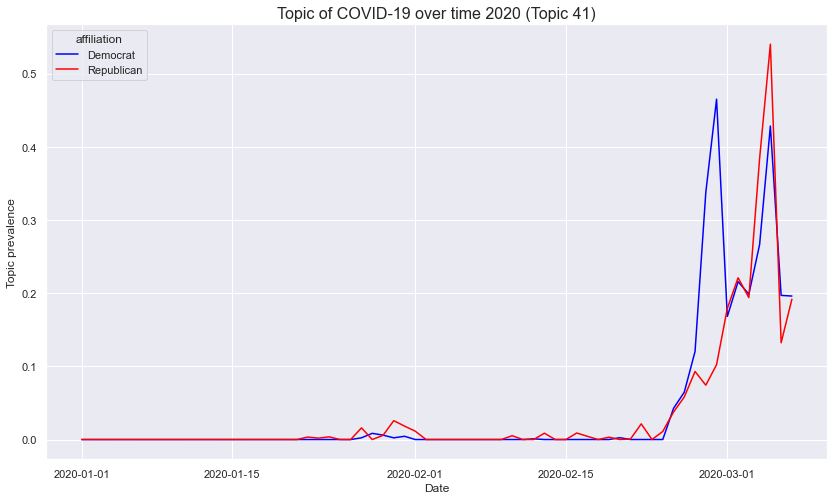

In [52]:
#Plotting the development of the covid topic for a 2020 subset of the dataset 

plt.figure(figsize = (14,8))
palette = ['blue','red']

sns.lineplot(x = 'date', y = 'topic_41', hue = 'affiliation', data = gamma_df.loc[gamma_df.date > datetime(2019,12,31)], palette = palette)

plt.title('Topic of COVID-19 over time 2020 (Topic 41)', fontsize = 16)
plt.ylabel('Topic prevalence')
plt.xlabel('Date')

plt.savefig('corona_topic_over_time2020_100topics_2.jpg')
plt.show()

#It is more clear here that Democracts 
#were the first to use the topic, since it is only shwoing dates after 31/12/2019

# 43 is impeachment, which the democrats also claimed

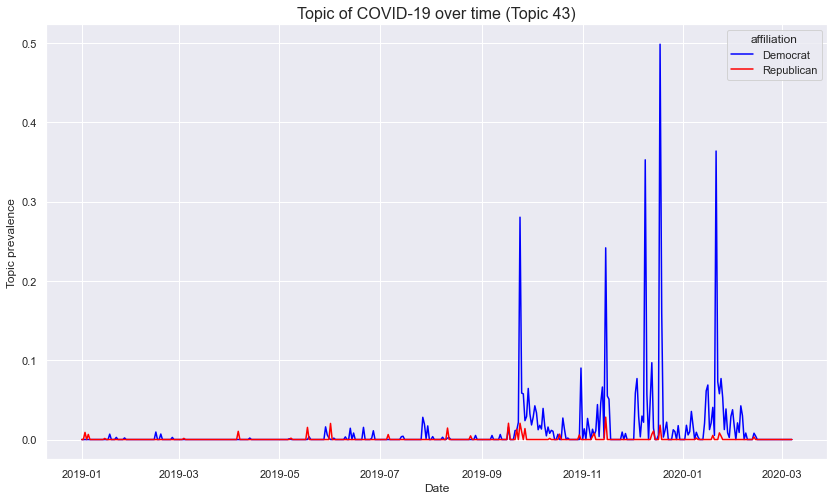

In [47]:
#Setting a theme
sns.set_theme(style="darkgrid")

#Plotting a figure and setting figure size
plt.figure(figsize = (14,8))

#Choosing colors
palette = ['blue','red'] 

#Plotting the covid topic for the full dataset
sns.lineplot(x = 'date', y = 'topic_43', hue = 'affiliation', data = gamma_df, palette = palette)

plt.title('Topic of COVID-19 over time (Topic 43)', fontsize = 16)
plt.ylabel('Topic prevalence')
plt.xlabel('Date')

plt.show()

#So, the democrats were faster

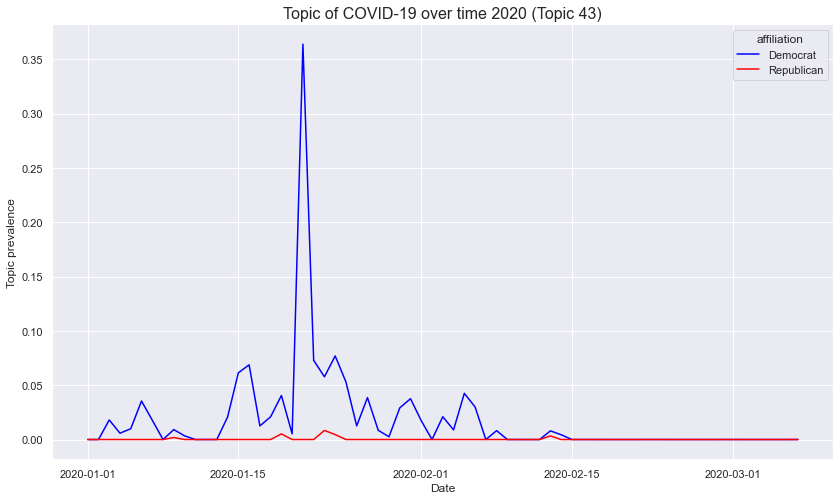

In [48]:
#Plotting the development of the covid topic for a 2020 subset of the dataset 

plt.figure(figsize = (14,8))
palette = ['blue','red']

sns.lineplot(x = 'date', y = 'topic_43', hue = 'affiliation', data = gamma_df.loc[gamma_df.date > datetime(2019,12,31)], palette = palette)

plt.title('Topic of COVID-19 over time 2020 (Topic 43)', fontsize = 16)
plt.ylabel('Topic prevalence')
plt.xlabel('Date')

plt.savefig('corona_topic_over_time2020_100topics_2.jpg')
plt.show()

#It is more clear here that Democracts 
#were the first to use the topic, since it is only shwoing dates after 31/12/2019